In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import re
import plotly as pl 
import matplotlib.pyplot as plt

In [2]:
file ="flavors_of_cacao.csv"
df_chocolate = pd.read_csv(file)
df_chocolate.head()

,Company,Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


# Cleaning Data

In [3]:
#Converting String Cocoa_Percent column into Integers
df_chocolate["Cocoa_Percent"] = df_chocolate["Cocoa_Percent"].str.replace('%', '')
df_chocolate['Cocoa_Percent'] = df_chocolate['Cocoa_Percent'].str.replace('.', '')
df_chocolate["Cocoa_Percent"]= df_chocolate["Cocoa_Percent"].astype(float)/100
df_chocolate["Cocoa_Percent"]

C:\Users\Tata\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


0       0.63
1       0.70
2       0.70
3       0.70
4       0.70
        ... 
1790    0.70
1791    0.65
1792    0.65
1793    0.62
1794    0.65
Name: Cocoa_Percent, Length: 1795, dtype: float64

In [4]:
df_chocolate.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  1795 non-null   object 
 1   Bean_Origin_or_Bar_Name  1795 non-null   object 
 2   REF                      1795 non-null   int64  
 3   Review_Date              1795 non-null   int64  
 4   Cocoa_Percent            1795 non-null   float64
 5   Company_Location         1795 non-null   object 
 6   Rating                   1795 non-null   float64
 7   Bean_Type                1794 non-null   object 
 8   Broad_Bean_Origin        1794 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 126.3+ KB


In [5]:
df_chocolate.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Company,1795,416,Soma,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bean_Origin_or_Bar_Name,1795,1039,Madagascar,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
REF,1795.0,NaN,NaN,NaN,1035.904735,552.886365,5.0,576.0,1069.0,1502.0,1952.0
Review_Date,1795.0,NaN,NaN,NaN,2012.325348,2.92721,2006.0,2010.0,2013.0,2015.0,2017.0
Cocoa_Percent,1795.0,NaN,NaN,NaN,0.741928,0.404268,0.42,0.7,0.7,0.75,7.35
Company_Location,1795,60,U.S.A.,764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,1795.0,NaN,NaN,NaN,3.185933,0.478062,1.0,2.875,3.25,3.5,5.0
Bean_Type,1794,41,,887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Broad_Bean_Origin,1794,100,Venezuela,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_chocolate.isnull().sum()

Company                    0
Bean_Origin_or_Bar_Name    0
REF                        0
Review_Date                0
Cocoa_Percent              0
Company_Location           0
Rating                     0
Bean_Type                  1
Broad_Bean_Origin          1
dtype: int64

In [7]:
# Determine the number of unique values in each column.
df_chocolate.nunique()

Company                     416
Bean_Origin_or_Bar_Name    1039
REF                         440
Review_Date                  12
Cocoa_Percent                45
Company_Location             60
Rating                       13
Bean_Type                    41
Broad_Bean_Origin           100
dtype: int64

In [8]:
# Replace empty BB_origin
df_chocolate['Broad_Bean_Origin'] = df_chocolate['Broad_Bean_Origin'].fillna(df_chocolate['Bean_Origin_or_Bar_Name'])

In [9]:
# Drop null values
df_chocolate.dropna(axis=0, how='any', inplace=True)

In [10]:
df_chocolate['Bean_Type'].value_counts()

                            887
Trinitario                  419
Criollo                     153
Forastero                    87
Forastero (Nacional)         52
Blend                        41
Criollo, Trinitario          39
Forastero (Arriba)           37
Criollo (Porcelana)          10
Trinitario, Criollo           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Matina                        3
EET                           3
Beniano                       3
Nacional (Arriba)             3
Criollo (Ocumare 61)          2
Criollo (Amarru)              2
Forastero (Catongo)           2
Criollo, Forastero            2
Amazon, ICS                   2
Nacional                      2
Trinitario (85% Criollo)      2
Amazon mix                    2
Trinitario, Forastero         2
Criollo, +                    1
Trinitario, Nacional          1
Amazon                        1
Blend-Forastero,Criollo       1
Criollo (Wild)                1
Criollo (Ocumare)             1
Criollo 

In [11]:
#replace the values in the bean_type column
def replace_beans (bean_type):
    #order of criollo, trinitario, and forastero was decided by seeing the number of times it appears
    if 'Criollo' in bean_type:
        return 'Criollo'
    elif 'Trinitario' in bean_type:
        return 'Trinitario'
    elif 'Forastero' in bean_type:
        return 'Forastero'
    else:
        return bean_type
    
df_chocolate['Bean_Type'] = df_chocolate['Bean_Type'].map(lambda bean_type: replace_beans(bean_type))

In [12]:
df_chocolate['Bean_Type'].value_counts()

                     887
Trinitario           426
Criollo              225
Forastero            195
Blend                 41
Matina                 3
EET                    3
Beniano                3
Nacional (Arriba)      3
Amazon mix             2
Amazon, ICS            2
Nacional               2
CCN51                  1
Amazon                 1
Name: Bean_Type, dtype: int64

In [13]:
list(df_chocolate['Bean_Type'][0:5])

['\xa0', '\xa0', '\xa0', '\xa0', '\xa0']

In [14]:
# Replace the weird spaces with None (Symbolizes no data) 

def repl_space(x):
    if(x is "\xa0"):
        return "None"

# apply()        
df_chocolate['Bean_Type'] = df_chocolate['Bean_Type'].apply(repl_space)
df_chocolate.head()

,Company,Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,None,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,None,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,None,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,None,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,None,Peru


In [15]:
df_chocolate['Company'].sort_values().unique()

array(['A. Morin', 'AMMA', 'Acalli', 'Adi', 'Aequare (Gianduja)',
       'Ah Cacao', "Akesson's (Pralus)", 'Alain Ducasse', 'Alexandre',
       'Altus aka Cao Artisan', 'Amano', 'Amatller (Simon Coll)',
       'Amazona', 'Ambrosia', 'Amedei', 'Anahata', 'Animas', 'Ara',
       'Arete', 'Artisan du Chocolat', 'Artisan du Chocolat (Casa Luker)',
       'Askinosie', 'Bahen & Co.', 'Bakau', 'Bar Au Chocolat',
       "Baravelli's", 'Batch', 'Beau Cacao', 'Beehive', 'Belcolade',
       'Bellflower', 'Belyzium', 'Benoit Nihant', 'Bernachon',
       'Beschle (Felchlin)', 'Bisou', 'Bittersweet Origins',
       'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
       'Blue Bandana', 'Bonnat', 'Bouga Cacao (Tulicorp)', 'Bowler Man',
       "Brasstown aka It's Chocolate", 'Brazen', 'Breeze Mill', 'Bright',
       'Britarev', 'Bronx Grrl Chocolate', 'Burnt Fork Bend', 'C-Amaro',
       'Cacao Arabuco', 'Cacao Atlanta', 'Cacao Barry', 'Cacao Hunters',
       'Cacao Market', 'Cacao Prieto', 'Ca

In [16]:
#Check spelling for Company Location values.
df_chocolate['Company_Location'].sort_values().unique()

array(['Amsterdam', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Bolivia', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Domincan Republic', 'Ecuador',
       'Eucador', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana',
       'Grenada', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Madagascar',
       'Martinique', 'Mexico', 'Netherlands', 'New Zealand', 'Niacragua',
       'Nicaragua', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Puerto Rico', 'Russia', 'Sao Tome', 'Scotland', 'Singapore',
       'South Africa', 'South Korea', 'Spain', 'St. Lucia', 'Suriname',
       'Sweden', 'Switzerland', 'U.K.', 'U.S.A.', 'Venezuela', 'Vietnam',
       'Wales'], dtype=object)

In [17]:
df_chocolate['Company_Location'] = df_chocolate['Company_Location'].str.replace('Domincan Republic', 'Dominican Republic')\
.str.replace('Eucador', 'Ecuador')\
.str.replace('Amsterdam','Netherlands')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('U.K.', 'England')\
.str.replace('U.S.A.', 'United States of America')

df_chocolate['Company_Location'].sort_values().unique()

C:\Users\Tata\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
C:\Users\Tata\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Bolivia',
       'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'England', 'Fiji', 'Finland', 'France', 'Germany', 'Ghana',
       'Grenada', 'Guatemala', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Lithuania', 'Madagascar',
       'Martinique', 'Mexico', 'Netherlands', 'New Zealand', 'Nicaragua',
       'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico',
       'Russia', 'Sao Tome', 'Scotland', 'Singapore', 'South Africa',
       'South Korea', 'Spain', 'St. Lucia', 'Suriname', 'Sweden',
       'Switzerland', 'United States of America', 'Venezuela', 'Vietnam',
       'Wales'], dtype=object)

In [18]:


## Text preparation (correction) function
def txt_prep(text):
    replacements = [
        ['\(', ','],['-', ','], ['/', ','], [' & ', ','], ['\)', ''], [' and ', ','],
        ['Dom Rep$|Dom Rep,|DR|Domin Rep|Dominican Rep$|Dominican Rep,|Domincan Republic', 'Dominican Republic,'],
        ['Mad,|Mad$', 'Madagascar,'],['PNG,|PNG$', 'Papua New Guinea,'],
        ['Guat,|Guat$', 'Guatemala,'], ['Ven,|Ven$|Venez,', 'Venezuela,'],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador,'],['Nic,|Nic$', 'Nicaragua,'],
        ['Cost Rica', 'Costa Rica'], ['Mex,|Mex$', 'Mexico,'],
        ['Jam$|Jam,', 'Jamaica,'], ['Haw$|Haw,', 'Hawaii,'], [' Bali', ',Bali'],
        ['Gre$|Gre,', 'Grenada,'], ['Tri,|Tri$', 'Trinidad, '], ['C Am', 'Central America'],
        ['S America', 'South America'], ['Central,', 'Central America,'],
        ['\\xa0', ' '], [',$',''], ['\.',''], [',,',','], [',\s+',','], ['\xa0', ' '] 
    ]
    for i, j in replacements:
        text = re.sub(i, j, str(text))
    return text



In [19]:
df_chocolate['Broad_Bean_Origin'].str.replace('.','').apply(txt_prep).unique()

C:\Users\Tata\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


array(['Sao Tome', 'Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama',
       'Madagascar', 'Brazil', 'Ecuador', 'Colombia', 'Burma',
       'Papua New Guinea', 'Bolivia', 'Fiji', 'Mexico', 'Indonesia',
       'Trinidad', 'Vietnam', 'Nicaragua', 'Tanzania',
       'Dominican Republic', 'Ghana', 'Belize', ' ', 'Jamaica', 'Grenada',
       'Guatemala', 'Honduras', 'Costa Rica', 'Haiti', 'Congo',
       'Philippines', 'Malaysia', 'Dominican Republic,Bali',
       'Venezuela,Africa,Brasil,Peru,Mexico', 'Gabon', 'Ivory Coast',
       'Carribean', 'Sri Lanka', 'Puerto Rico', 'Uganda', 'Martinique',
       'Sao Tome,Principe', 'Vanuatu', 'Australia', 'Liberia',
       'Ecuador,Costa Rica', 'West Africa', 'Hawaii', 'St Lucia',
       'Costa Rica,Venezuela', 'Peru,Madagascar', 'Venezuela,Trinidad',
       'Trinidad,Tobago', 'Venezuela,Trinidad,Ecuador',
       'South America,Africa', 'India',
       'Africa,Carribean,Central America', 'Tobago',
       'Venezuela,Indonesia,Ecuador', 'Peru,Ecuador,Ven

In [20]:
df_chocolate['Broad_Bean_Origin']= df_chocolate['Broad_Bean_Origin'].str.replace('.','').apply(txt_prep)


C:\Users\Tata\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [21]:
df_chocolate['Broad_Bean_Origin'].value_counts().head(10)

Venezuela             214
Ecuador               193
Dominican Republic    166
Peru                  165
Madagascar            146
                       73
Nicaragua              60
Brazil                 58
Bolivia                57
Belize                 49
Name: Broad_Bean_Origin, dtype: int64

In [22]:
df_chocolate.drop(list(df_chocolate[df_chocolate['Broad_Bean_Origin'] == ' '].index), axis=0, inplace=True)

In [23]:
df_chocolate['Broad_Bean_Origin'].value_counts().head(20)

Venezuela             214
Ecuador               193
Dominican Republic    166
Peru                  165
Madagascar            146
Nicaragua              60
Brazil                 58
Bolivia                57
Belize                 49
Papua New Guinea       42
Colombia               40
Vietnam                38
Costa Rica             38
Tanzania               34
Ghana                  33
Trinidad               33
Mexico                 30
Hawaii                 28
Guatemala              28
Jamaica                20
Name: Broad_Bean_Origin, dtype: int64

<AxesSubplot:ylabel='Density'>

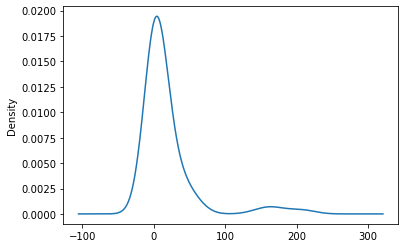

In [24]:
df_chocolate['Broad_Bean_Origin'].value_counts().plot.density()

In [25]:
df_chocolate['Rating'].value_counts()

3.50    376
3.00    329
3.25    292
2.75    250
3.75    205
2.50    123
4.00     95
2.00     26
2.25     14
1.50      5
1.75      3
1.00      2
5.00      1
Name: Rating, dtype: int64

In [26]:
df_chocolate['Cocoa_Percent'].sort_values().unique()

array([0.42, 0.46, 0.5 , 0.53, 0.55, 0.56, 0.57, 0.58, 0.6 , 0.61, 0.62,
       0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73,
       0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84,
       0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.99, 1.  , 6.05, 7.25,
       7.35])

In [27]:
df_chocolate.drop(df_chocolate[df_chocolate['Cocoa_Percent']>1].index, axis=0, inplace=True)

In [28]:
df_chocolate.to_csv('data_cleaned.csv', index=False)

# Answering Questions

## Where are the best cocoa beans grown?

In [29]:
df_chocolate[df_chocolate['Rating']==5.00]

,Company,Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
78,Amedei,Chuao,111,2007,0.7,Italy,5.0,None,Venezuela


In [30]:
df_chocolate[df_chocolate['Rating']>=4.00]

,Company,Bean_Origin_or_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
9,A. Morin,Pablino,1319,2014,0.70,France,4.0,None,Peru
17,A. Morin,Chuao,1015,2013,0.70,France,4.0,None,Venezuela
20,A. Morin,Chanchamayo Province,1019,2013,0.63,France,4.0,None,Peru
54,Amano,Morobe,725,2011,0.70,United States of America,4.0,None,Papua New Guinea
56,Amano,Guayas,470,2010,0.70,United States of America,4.0,None,Ecuador
...,...,...,...,...,...,...,...,...,...
1687,Valrhona,"Porcelana, Pedegral",757,2011,0.64,France,4.0,None,Venezuela
1693,Valrhona,Manjari,129,2007,0.64,France,4.0,None,Madagascar
1699,Valrhona,Guanaja,63,2006,0.70,France,4.0,None,South America
1739,Willie's Cacao,Los Llanos,1848,2016,0.70,England,4.0,None,Colombia


#### Some similarities we can see: The Companie's Name, Cocoa Percent values and Company's Location  are the same.

In [31]:
df_chocolate['Broad_Bean_Origin'].value_counts().head(20)

Venezuela             213
Ecuador               192
Dominican Republic    165
Peru                  165
Madagascar            144
Nicaragua              60
Brazil                 58
Bolivia                57
Belize                 49
Papua New Guinea       42
Colombia               40
Vietnam                38
Costa Rica             38
Tanzania               34
Ghana                  33
Trinidad               33
Mexico                 30
Hawaii                 28
Guatemala              28
Jamaica                20
Name: Broad_Bean_Origin, dtype: int64

In [32]:
countries=df_chocolate['Broad_Bean_Origin'].value_counts().index.tolist()[:5]
countries

['Venezuela', 'Ecuador', 'Dominican Republic', 'Peru', 'Madagascar']

In [33]:
Broad_Bean_Origin_mean = df_chocolate.groupby('Broad_Bean_Origin').mean().reset_index()
Broad_Bean_Origin_mean

,Broad_Bean_Origin,REF,Review_Date,Cocoa_Percent,Rating
0,"Africa,Carribean,Central America",1121.000000,2013.000000,0.740000,2.750000
1,Australia,1434.333333,2014.000000,0.690000,3.250000
2,Belize,1414.897959,2014.387755,0.734490,3.234694
3,Bolivia,1152.719298,2013.052632,0.717018,3.197368
4,Brazil,1082.482759,2012.568966,0.711379,3.284483
...,...,...,...,...,...
90,"Venezuela,Trinidad",672.000000,2011.000000,0.620000,2.500000
91,"Venezuela,Trinidad,Ecuador",355.000000,2009.000000,0.640000,3.250000
92,"Venezuela,Trinidad,Madagascar",227.000000,2008.000000,0.720000,3.000000
93,Vietnam,1403.526316,2014.131579,0.735263,3.315789


In [34]:
best_beans_grown = Broad_Bean_Origin_mean[Broad_Bean_Origin_mean['Rating'] >= 4.0]
best_beans_grown

,Broad_Bean_Origin,REF,Review_Date,Cocoa_Percent,Rating
19,"Dominican Republic,Madagascar",867.0,2012.0,0.70,4.0
31,"Grenada,Papua New Guinea,Hawaii,Haiti,Madagascar",867.0,2012.0,0.70,4.0
33,"Guatemala,Dominican Republic,Peru,Madagascar,P...",1077.0,2013.0,0.88,4.0
56,"Peru,Dominican Republic",1081.0,2013.0,0.67,4.0
89,"Venezuela,Java",111.0,2007.0,0.70,4.0


In [35]:
best_beans_grown.Broad_Bean_Origin.tolist()

['Dominican Republic,Madagascar',
 'Grenada,Papua New Guinea,Hawaii,Haiti,Madagascar',
 'Guatemala,Dominican Republic,Peru,Madagascar,Papua New Guinea',
 'Peru,Dominican Republic',
 'Venezuela,Java']

### It seems that the best cocoa beans are grown from a combination of Dominican Republic, Madagascar, Grenada, Papua New Guinea, Hawaii, Haiti, Guatemala, Peru, Venezuela, Bolivia, and Java.

## Which countries produce the highest-rated bars?

In [36]:
company_location=df_chocolate['Company_Location'].value_counts().index.tolist()

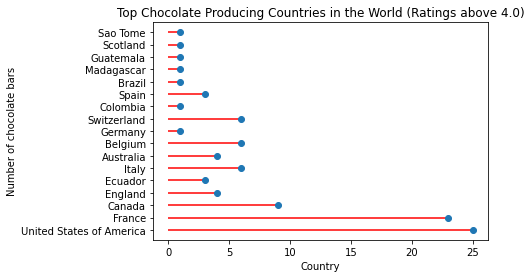

{'United States of America': 25, 'France': 23, 'Canada': 9, 'England': 4, 'Ecuador': 3, 'Italy': 6, 'Australia': 4, 'Belgium': 6, 'Germany': 1, 'Switzerland': 6, 'Colombia': 1, 'Spain': 3, 'Brazil': 1, 'Madagascar': 1, 'Guatemala': 1, 'Scotland': 1, 'Sao Tome': 1}


In [37]:
best_choc={}
for cl in company_location:
    c=0
    b=df_chocolate[df_chocolate['Company_Location']==cl]
    br=b[b['Rating']>=4]
    for i in br['Rating']:
        
        c+=1
        best_choc[cl]=c
li=best_choc.keys()


# The lollipop plot
plt.hlines(y=li,xmin=0,xmax=best_choc.values(),color='red')
plt.plot(best_choc.values(),li,"o")
plt.xlabel('Country')
plt.ylabel('Number of chocolate bars')
plt.title("Top Chocolate Producing Countries in the World (Ratings above 4.0)")
plt.show()
print(best_choc)

### USA and France produce the highest-rated bars.

## What’s the relationship between cocoa solids percentage and rating?

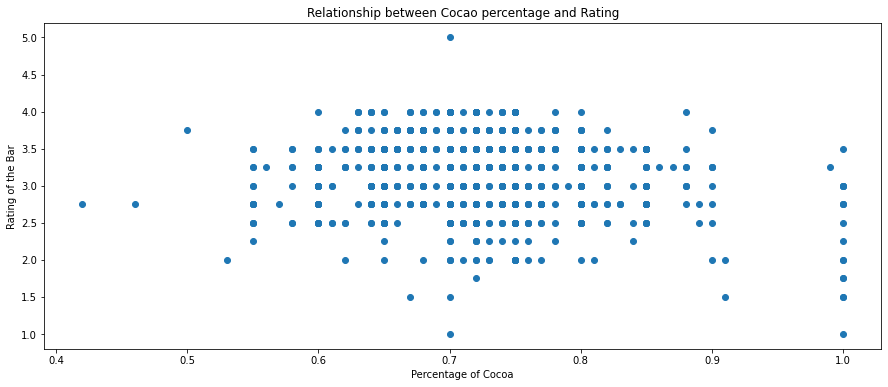

In [38]:
plt.subplots(figsize=(15, 6))
plt.scatter(x="Cocoa_Percent", y="Rating", data=df_chocolate)
plt.title("Relationship between Cocao percentage and Rating")
plt.xlabel('Percentage of Cocoa')
plt.ylabel('Rating of the Bar')
plt.show()

# Machine Learning Neural Network!



In [39]:
def bin_ratings(rating):
    if rating == 5.75: return 1
    if rating == 5.50: return 1
    if rating == 5.25: return 1
    if rating == 5.00: return 1
    
    if rating == 4.75: return 1
    if rating == 4.50: return 1
    if rating == 4.25: return 1
    if rating == 4.00: return 1
    
    if rating == 3.75: return 0
    if rating == 3.50: return 0
    if rating == 3.25: return 0
    if rating == 3.00: return 0

    if rating == 2.75: return 0
    if rating == 2.50: return 0
    if rating == 2.25: return 0
    if rating == 2.00: return 0
    
    if rating == 1.75: return 0
    if rating == 1.50: return 0
    if rating == 1.25: return 0
    if rating == 1.00: return 0
    
    #print( f"error: rating={rating} type={type(rating)}" )
    return "2"

In [40]:
df_chocolate['Rating'] = df_chocolate['Rating'].apply(bin_ratings)
df_chocolate['Rating']

0       0
1       0
2       0
3       0
4       0
       ..
1790    0
1791    0
1792    0
1793    0
1794    0
Name: Rating, Length: 1714, dtype: int64

In [41]:
def to_string(value):
    other = f"_{value}_"
    return other

In [42]:
def reduce_count_vals(df, colname, threshold):
    counts = df[colname].value_counts()
    replace_list = list(counts[counts < threshold].index)

    # Replace in dataframe
    for item in replace_list:
       df[colname] = df[colname].replace(item,"Other")

In [43]:
df_chocolate['Review_Date']= df_chocolate['Review_Date'].apply(to_string)
reduce_count_vals(df_chocolate, 'Review_Date', 100)

In [44]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
df_chocolate= df_chocolate.drop(columns=["Company", "REF","Bean_Origin_or_Bar_Name"], axis=1)
df_chocolate.head()

,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,_2016_,0.63,France,0,None,Sao Tome
1,_2015_,0.70,France,0,None,Togo
2,_2015_,0.70,France,0,None,Togo
3,_2015_,0.70,France,0,None,Togo
4,_2015_,0.70,France,0,None,Peru


In [45]:
# Generate our categorical variable lists
chocolate_cat = df_chocolate.dtypes[df_chocolate.dtypes == 'object'].index.tolist()
chocolate_cat

['Review_Date', 'Company_Location', 'Bean_Type', 'Broad_Bean_Origin']

In [46]:


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df_chocolate[chocolate_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(chocolate_cat)
encode_df.head()



,Review_Date_Other,Review_Date__2009_,Review_Date__2010_,Review_Date__2011_,Review_Date__2012_,Review_Date__2013_,Review_Date__2014_,Review_Date__2015_,Review_Date__2016_,Company_Location_Argentina,...,"Broad_Bean_Origin_Venezuela,Dominican Republic","Broad_Bean_Origin_Venezuela,Ecuador,Peru,Nicaragua","Broad_Bean_Origin_Venezuela,Ghana","Broad_Bean_Origin_Venezuela,Indonesia,Ecuador","Broad_Bean_Origin_Venezuela,Java","Broad_Bean_Origin_Venezuela,Trinidad","Broad_Bean_Origin_Venezuela,Trinidad,Ecuador","Broad_Bean_Origin_Venezuela,Trinidad,Madagascar",Broad_Bean_Origin_Vietnam,Broad_Bean_Origin_West Africa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Merge one-hot encoded features and drop the originals
df_chocolate = df_chocolate.merge(encode_df, left_index=True, right_index=True).drop(chocolate_cat, 1)
df_chocolate.head()

,Cocoa_Percent,Rating,Review_Date_Other,Review_Date__2009_,Review_Date__2010_,Review_Date__2011_,Review_Date__2012_,Review_Date__2013_,Review_Date__2014_,Review_Date__2015_,...,"Broad_Bean_Origin_Venezuela,Dominican Republic","Broad_Bean_Origin_Venezuela,Ecuador,Peru,Nicaragua","Broad_Bean_Origin_Venezuela,Ghana","Broad_Bean_Origin_Venezuela,Indonesia,Ecuador","Broad_Bean_Origin_Venezuela,Java","Broad_Bean_Origin_Venezuela,Trinidad","Broad_Bean_Origin_Venezuela,Trinidad,Ecuador","Broad_Bean_Origin_Venezuela,Trinidad,Madagascar",Broad_Bean_Origin_Vietnam,Broad_Bean_Origin_West Africa
0,0.63,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.70,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.70,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.70,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.70,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Split our preprocessed data into our features and target arrays
y = df_chocolate["Rating"].values
X = df_chocolate.drop(["Rating"],1).values 

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [49]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [50]:
len(X_train_scaled[0])

164

In [51]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  256
hidden_nodes_layer2 = 128
hidden_nodes_layer3 = 64
hidden_nodes_layer4 = 32
hidden_nodes_layer5 = 16
hidden_nodes_layer6 = 8
hidden_nodes_layer7 = 4


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, input_dim = number_input_features, activation = 'relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = 'relu'))

# other hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer3, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer4, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer5, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = 'relu'))
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer7, activation = 'relu'))


# Output layer
nn.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               42240     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 3

In [52]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [53]:
# Compile the model
nn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics= ['accuracy'])

In [54]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [55]:
# Train the model
nn.fit(X_train_scaled, y_train, epochs = 100, callbacks=[cp_callback])

Epoch 1/100
39/39 [==============================] - 1s 3ms/step - loss: 0.3683 - accuracy: 0.9357
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2435 - accuracy: 0.9357
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9357
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9357
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.1785 - accuracy: 0.9357

Epoch 00005: saving model to checkpoints\weights.05.hdf5
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1659 - accuracy: 0.9357
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.9357
Epoch 8/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1424 - accuracy: 0.9357
Epoch 9/100
39/39 [==============================] - 0s 3ms/step - loss: 0.1341 - accuracy: 0.9381
Epoch 10/100
39/39 [==============================]

39/39 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.9756
Epoch 75/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0428 - accuracy: 0.9756

Epoch 00075: saving model to checkpoints\weights.75.hdf5
Epoch 76/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0426 - accuracy: 0.9748
Epoch 77/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0427 - accuracy: 0.9748
Epoch 78/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0436 - accuracy: 0.9748
Epoch 79/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0462 - accuracy: 0.9756
Epoch 80/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0708 - accuracy: 0.9715

Epoch 00080: saving model to checkpoints\weights.80.hdf5
Epoch 81/100
39/39 [==============================] - 0s 3ms/step - loss: 0.0526 - accuracy: 0.9731
Epoch 82/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0648 - accuracy: 0.96

In [56]:


# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")



13/13 - 0s - loss: 0.9367 - accuracy: 0.9366
Loss: 0.9366717338562012, Accuracy: 0.9365853667259216


In [57]:
nn.save("AlphabetSoupCharity.h5")